In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import decimate

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py'>

In [3]:
## Calibration values for Sphere 20250103
c_mv = 8.263269630174246e-08
amp2kev = 7157.624533259538
sigma_p = 176.79818534573002  # keV/c

In [4]:

def gaus(x, x0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - x0)**2 / (2 * sigma**2))

def search_expectation(x0, alpha, amp2kev, sig_amp):
    sigma = sig_amp * amp2kev
    bias = alpha * sigma

    first = bias * 0.5 * ( erf((bias - x0)/(np.sqrt(2) * sigma)) - erf((-1 * bias - x0)/(np.sqrt(2) * sigma)) )

    xx0 = np.linspace(bias, x0 + 5*sigma, 1000)
    second = np.trapz(gaus(xx0, x0, sigma) * np.abs(xx0), xx0, axis=0)

    xx1 = np.linspace(x0 - 5*sigma, -1 * bias, 1000)
    third = np.trapz(gaus(xx1, x0, sigma) * np.abs(xx1), xx1, axis=0)

    return (first + second + third) / amp2kev

In [5]:
def get_pulse_shape_template(sphere, voltage, amp2kev):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0) * amp2kev

    return pulse_shape_template

def get_normalized_template_all(sphere, voltages):
    """Peak-normalized template averaged over all pulses of different amplitudes"""
    waveform_normalized_all = []
    for voltage in voltages:
        pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
        pulse_shapes = pulse_shape_file['pulse_shape']

        pulse_shapes_normalized = np.empty_like(pulse_shapes)
        for i, pulse in enumerate(pulse_shapes):
            pulse_shapes_normalized[i] = pulse / np.max(pulse)

            if np.max(pulse_shapes_normalized[i] > 1.0):
                print(np.max(pulse_shapes_normalized[i]))

        waveform_normalized_all.append(pulse_shapes_normalized)

    waveform_normalized_all = np.concatenate(waveform_normalized_all, axis=0)
    pulse_shape_template = np.mean(np.asarray(waveform_normalized_all), axis=0)

    return pulse_shape_template

In [79]:
def get_detection_efficiency(normalized_amps, sigmas, threshold=5):
    eff, eff_err = [], []
    for i, amps in enumerate(normalized_amps):
        count = np.count_nonzero(amps > threshold * sigmas[i])
        eff.append(count / amps.size)
        eff_err.append(np.sqrt(count) / amps.size)

    return eff, eff_err

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

In [6]:
## First derive the calibration factor for plotting
data_files = [r'/Volumes/LaCie/dm_data/sphere_20250103/20250114_1e-8mbar1e_10vp2p_0.hdf5']
c_mvs = utils.get_c_mv(data_files, [10], 93000*2*np.pi, passband=(91700, 94300), charge=1, n_chunk=60)

c_mv = np.mean(c_mvs)

## Calibration

#### Sphere 20250103

In [146]:
outfile_name = 'sphere_20250103_calibration_unnormalized_amps.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['processed_amplitudes']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])
unnormalized_amps_all_sphere_20250103 = unnormalized_amps_all_flattened

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

bins = np.arange(0, 2500, 50) / 7158

hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Fitted resolution: 176.79818534573002 keV/c
Averaged `amp2keV`: 7157.624533259538


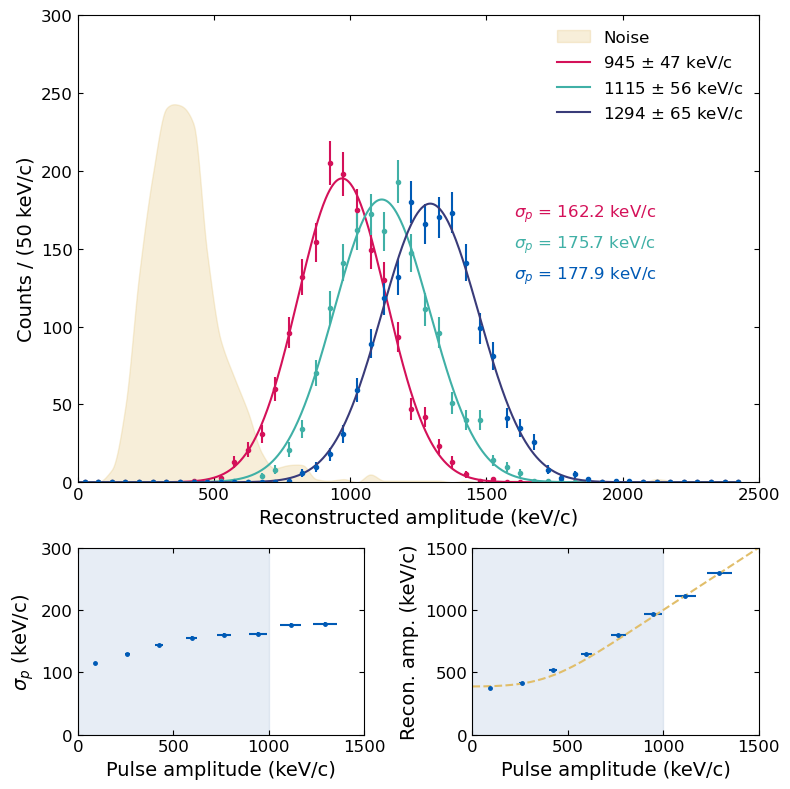

In [ ]:
xx = np.linspace(0, 1500, 500)
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05
n_pulses = np.asarray([amps.size for amps in unnormalized_amps_all_flattened])

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[2.5, 1])
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

# First plot
ax = ax0
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 / gps[7][1]

from scipy.interpolate import Akima1DInterpolator
xs = np.linspace(np.min(bcs[0]), np.max(bcs[0]), 500)
y_makima = Akima1DInterpolator(bcs[0], hh_noise, method="makima")(xs)

# ax.fill_between(bcs[0]*amp2kev_all, hh_noise, color='#E1BE6A', alpha=0.25, label='Noise')
ax.fill_between(xs*amp2kev_all, y_makima, color='#E1BE6A', alpha=0.25, label='Noise')

ax.errorbar(bcs[0]*amp2kev_all, hhs[5], yerr=np.sqrt(hhs[5]), fmt='.', color='#D41159')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[5]), label=fr'945 $\pm$ {945*0.05:.0f} keV/c', color='#D41159')

ax.errorbar(bcs[0]*amp2kev_all, hhs[6], yerr=np.sqrt(hhs[6]), fmt='.', color='#40B0A6')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[6]), label=fr'1115 $\pm$ {1115*0.05:.0f} keV/c', color='#40B0A6')

ax.errorbar(bcs[0]*amp2kev_all, hhs[7], yerr=np.sqrt(hhs[7]), fmt='.', color='#005AB5')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=fr'1294 $\pm$ {1294*0.05:.0f} keV/c')

ax.text(1600, 170, fr'$\sigma_p$ = {gps[5][2]*amp2kev_all:.1f} keV/c', color='#D41159', fontsize=12)
ax.text(1600, 150, fr'$\sigma_p$ = {gps[6][2]*amp2kev_all:.1f} keV/c', color='#40B0A6', fontsize=12)
ax.text(1600, 130, fr'$\sigma_p$ = {gps[7][2]*amp2kev_all:.1f} keV/c', color='#005AB5', fontsize=12)

ax.legend(frameon=False, fontsize=12)
ax.set_xlabel(r'Reconstructed amplitude (keV/c)')
ax.set_ylabel(fr'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)
ax.set_ylim(0, 300)

# Second plot fo resolution
ax = ax1

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
ax.errorbar(pulseamps, sig_p_avg, yerr=sig_p_avg/np.sqrt(2 * (n_pulses-1)), xerr=pulseamps_err, 
            fmt='.', markersize=5, color='#005AB5')

idx_fit = pulseamps > 1000
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
xx = np.linspace(1000, 4000, 500)
# ax.plot(xx, np.full_like(xx, popt_sig[0]), '--', color='#E1BE6A')
ax.fill_betweenx(np.linspace(0, 300, 100), 0, 1000, color='#B0C4DE', alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlim(0, 1500)
ax.set_xlabel(r'Pulse amplitude (keV/c)')
ax.set_ylabel(r'$\sigma_p$ (keV/c)')

# Third plot for search bias
ax = ax2
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

# Fit for search bias
f_bias = lambda x, alpha: search_expectation(x, alpha, amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all
popt_bias, pcov_bias = curve_fit(f_bias, pulseamps, amps*amp2kev_all, p0=[0.87], sigma=sig_p_avg/np.sqrt(n_pulses))

ax.errorbar(pulseamps, amps*amp2kev_all, yerr=amps_std*amp2kev_all/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color='#005AB5')
ax.fill_betweenx(np.linspace(0, 1500, 100), 0, 1000, color='#B0C4DE', alpha=0.3)
xx = np.linspace(0, 4000, 500)
ax.plot(xx, f_bias(xx, *popt_bias), '--', color='#E1BE6A', 
             label=fr'$\sigma_{{p, 0}}$={popt_sig[-1]:.0f} keV/c\n$\sigma_b$ = {popt_sig[-1]*popt_bias[-1]:.0f} keV/c')

ax.set_ylim(0, 1500)
ax.set_xlim(0, 1500)
ax.set_xlabel(r'Pulse amplitude (keV/c)')
ax.set_ylabel(r'Recon. amp. (keV/c)')

fig.tight_layout()
fig.align_labels()

plt.savefig('/Users/yuhan/work/nanospheres/dm_nanospheres/paper_plots/impulse_calibration_sphere_20250103.pdf', dpi=600)

print(f'Fitted resolution: {popt_sig[-1]} keV/c')
print(f'Averaged `amp2keV`: {amp2kev_all}')

#### Sphere 20241202

In [84]:
outfile_name = 'sphere_20241202_calibration_unnormalized_amps.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['processed_amplitudes']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])
unnormalized_amps_all_sphere_20241202 = unnormalized_amps_all_flattened

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

bins = np.arange(0, 2500, 50) / 7187.6

hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Fitted resolution: 171.44101566516954 keV/c
Averaged `amp2keV`: 7187.368332843102


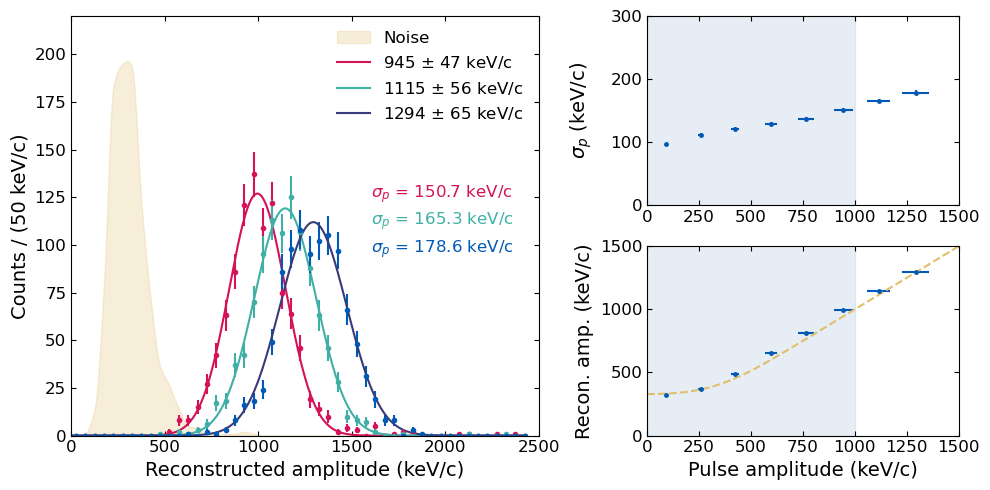

In [10]:
xx = np.linspace(0, 1500, 500)
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05
n_pulses = np.asarray([amps.size for amps in unnormalized_amps_all_flattened])

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[3])

# First plot
ax = ax0
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 / gps[7][1]

from scipy.interpolate import Akima1DInterpolator
xs = np.linspace(np.min(bcs[0]), np.max(bcs[0]), 500)
y_makima = Akima1DInterpolator(bcs[0], hh_noise, method="makima")(xs)

# ax.fill_between(bcs[0]*amp2kev_all, hh_noise, color='#E1BE6A', alpha=0.25, label='Noise')
ax.fill_between(xs*amp2kev_all, y_makima, color='#E1BE6A', alpha=0.25, label='Noise')

ax.errorbar(bcs[0]*amp2kev_all, hhs[5], yerr=np.sqrt(hhs[5]), fmt='.', color='#D41159')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[5]), label=fr'945 $\pm$ {945*0.05:.0f} keV/c', color='#D41159')

ax.errorbar(bcs[0]*amp2kev_all, hhs[6], yerr=np.sqrt(hhs[6]), fmt='.', color='#40B0A6')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[6]), label=fr'1115 $\pm$ {1115*0.05:.0f} keV/c', color='#40B0A6')

ax.errorbar(bcs[0]*amp2kev_all, hhs[7], yerr=np.sqrt(hhs[7]), fmt='.', color='#005AB5')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=fr'1294 $\pm$ {1294*0.05:.0f} keV/c')

ax.text(1600, 170*22/30, fr'$\sigma_p$ = {gps[5][2]*amp2kev_all:.1f} keV/c', color='#D41159', fontsize=12)
ax.text(1600, 150*22/30, fr'$\sigma_p$ = {gps[6][2]*amp2kev_all:.1f} keV/c', color='#40B0A6', fontsize=12)
ax.text(1600, 130*22/30, fr'$\sigma_p$ = {gps[7][2]*amp2kev_all:.1f} keV/c', color='#005AB5', fontsize=12)

ax.legend(frameon=False, fontsize=12)
ax.set_xlabel(r'Reconstructed amplitude (keV/c)')
ax.set_ylabel(fr'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)
ax.set_ylim(0, 220)

# Second plot fo resolution
ax = ax1

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
ax.errorbar(pulseamps, sig_p_avg, yerr=sig_p_avg/np.sqrt(2 * (n_pulses-1)), xerr=pulseamps_err, 
            fmt='.', markersize=5, color='#005AB5')

idx_fit = pulseamps > 1000
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
xx = np.linspace(1000, 4000, 500)
# ax.plot(xx, np.full_like(xx, popt_sig[0]), '--', color='#E1BE6A')
ax.fill_betweenx(np.linspace(0, 300, 100), 0, 1000, color='#B0C4DE', alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlim(0, 1500)
ax.set_ylabel(r'$\sigma_p$ (keV/c)')

# Third plot for search bias
ax = ax2
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

# Fit for search bias
f_bias = lambda x, alpha: search_expectation(x, alpha, amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all
popt_bias, pcov_bias = curve_fit(f_bias, pulseamps, amps*amp2kev_all, p0=[0.87], sigma=sig_p_avg/np.sqrt(n_pulses))

ax.errorbar(pulseamps, amps*amp2kev_all, yerr=amps_std*amp2kev_all/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color='#005AB5')
ax.fill_betweenx(np.linspace(0, 1500, 100), 0, 1000, color='#B0C4DE', alpha=0.3)
xx = np.linspace(0, 4000, 500)
ax.plot(xx, f_bias(xx, *popt_bias), '--', color='#E1BE6A', 
             label=fr'$\sigma_{{p, 0}}$={popt_sig[-1]:.0f} keV/c\n$\sigma_b$ = {popt_sig[-1]*popt_bias[-1]:.0f} keV/c')

ax.set_ylim(0, 1500)
ax.set_xlim(0, 1500)
ax.set_xlabel(r'Pulse amplitude (keV/c)')
ax.set_ylabel(r'Recon. amp. (keV/c)')

fig.tight_layout()
fig.align_labels()

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/impulse_calibration_sphere_20250103.pdf', dpi=600)

print(f'Fitted resolution: {popt_sig[-1]} keV/c')
print(f'Averaged `amp2keV`: {amp2kev_all}')

#### Sphere 20241221

In [137]:
outfile_name = 'sphere_20241221_calibration_unnormalized_amps.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['processed_amplitudes']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

bins = np.arange(0, 2500, 50) / 6471.980532780971

hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Fitted resolution: 162.34784893238404 keV/c
Averaged `amp2keV`: 6470.190290219283


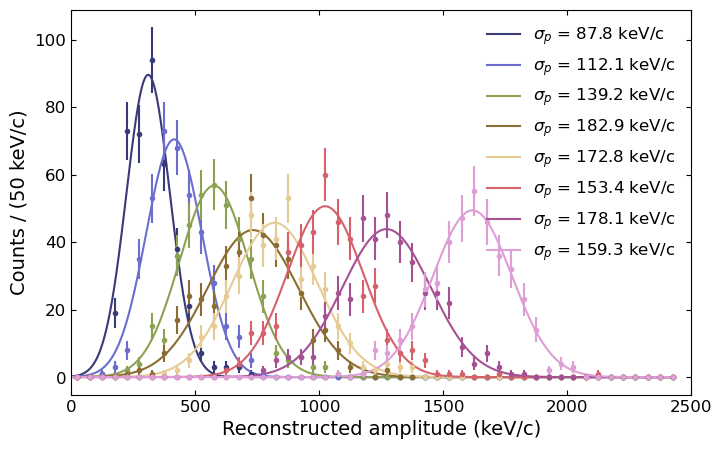

In [138]:
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 * 10 / 8 / gps[7][1]

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.colormaps.get_cmap('tab20b').resampled(8).colors
for i in range(8):
    ax.errorbar(bcs[0]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), color=colors[i], label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/c')

ax.legend(frameon=False)

ax.set_xlabel(r'Reconstructed amplitude (keV/c)')
ax.set_ylabel(fr'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
idx_fit = pulseamps * 10 / 8 > 1000
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))

print(f'Fitted resolution: {popt_sig[-1]} keV/c')
print(f'Averaged `amp2keV`: {amp2kev_all}')


#### Sphere 20241226

In [135]:
outfile_name = 'sphere_20241226_calibration_unnormalized_amps.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['processed_amplitudes']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

bins = np.arange(0, 2500, 50) / 6960.858276125061

hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Fitted resolution: 136.24214178893865 keV/c
Averaged `amp2keV`: 6959.135681055844


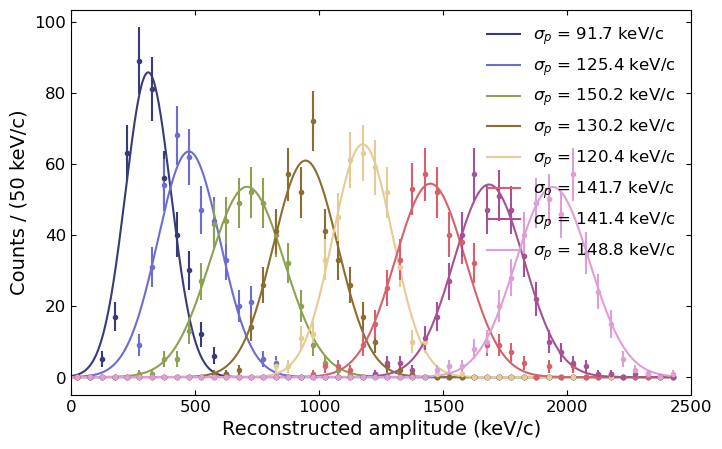

In [136]:
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 * 12 / 8 / gps[7][1]

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.colormaps.get_cmap('tab20b').resampled(8).colors
for i in range(8):
    ax.errorbar(bcs[0]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), color=colors[i], label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/c')

ax.legend(frameon=False)

ax.set_xlabel(r'Reconstructed amplitude (keV/c)')
ax.set_ylabel(fr'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
idx_fit = pulseamps * 12 / 8 > 1000
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))

print(f'Fitted resolution: {popt_sig[-1]} keV/c')
print(f'Averaged `amp2keV`: {amp2kev_all}')


## Derive signal efficiencies from the combined dataset

In [97]:
sigma_p_sphere_20241202 = 171.44101566516954
amp2kev_sphere_20241202 = 7187.368332843102

sigma_p_sphere_20250103 = 176.79818534573002
amp2kev_sphere_20250103 = 7157.624533259538

normalized_amps_all_sphere_20241202 = [a * amp2kev_sphere_20241202 for a in unnormalized_amps_all_sphere_20241202]
normalized_amps_all_sphere_20250103 = [a * amp2kev_sphere_20250103 for a in unnormalized_amps_all_sphere_20250103]

eff_20241202, eff_err_20241202 = get_detection_efficiency(normalized_amps_all_sphere_20241202, np.full(8, sigma_p_sphere_20241202), 5)
eff_20250103, eff_err_20250103 = get_detection_efficiency(normalized_amps_all_sphere_20250103, np.full(8, sigma_p_sphere_20250103), 5)

pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
popt_20241202, pcov_20241202 = curve_fit(func2, pulseamps, eff_20241202, p0=[850, 0.001], sigma=eff_err_20241202, maxfev=5000)
popt_20250103, pcov_20250103 = curve_fit(func2, pulseamps, eff_20250103, p0=[850, 0.001], sigma=eff_err_20250103, maxfev=5000)

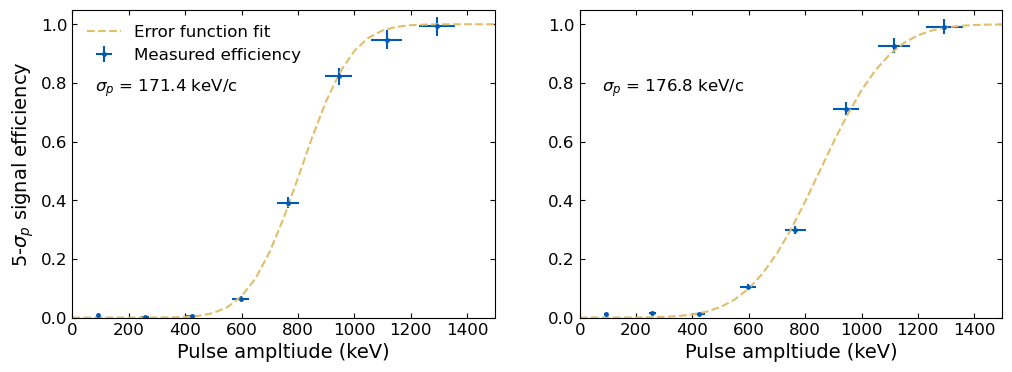

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

xx = np.arange(0, 10000, 50)
# f = np.interp(xx, pulseamps, eff)

ax = axes[0]
ax.errorbar(pulseamps, eff_20241202, yerr=eff_err_20241202, xerr=pulseamps_err, fmt='.', markersize=5, label='Measured efficiency', color='#005AB5')
ax.plot(xx, func2(xx, *popt_20241202), '--',label='Error function fit', color='#E1BE6A')
ax.text(80, 0.77, fr'$\sigma_p$ = {sigma_p_sphere_20241202:.1f} keV/c', fontsize=12)
ax.legend(frameon=False)

ax = axes[1]
ax.errorbar(pulseamps, eff_20250103, yerr=eff_err_20250103, xerr=pulseamps_err, fmt='.', markersize=5, label='Measured efficiency', color='#005AB5')
ax.plot(xx, func2(xx, *popt_20250103), '--',label='Error function fit', color='#E1BE6A')
ax.text(80, 0.77, fr'$\sigma_p$ = {sigma_p_sphere_20250103:.1f} keV/c', fontsize=12)

for ax in axes:
    ax.set_xlim(0, 1500)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Pulse ampltiude (keV)')
axes[0].set_ylabel(r'5-$\sigma_p$ signal efficiency')

plt.savefig('/Users/yuhan/work/nanospheres/dm_nanospheres/paper_plots/signal_efficiency_sphere_combined.pdf', dpi=600)

In [147]:
outfile_name = 'sphere_combined_calibration.h5py'
out_dir = '/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/sphere_data'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('calibration_sphere_20241202')
    g.attrs['amp2kev'] = amp2kev_sphere_20241202
    g.attrs['sigma_p_kev'] = sigma_p_sphere_20241202
    g.create_dataset(f'sig_efficiency_fit_params', data=popt_20241202, dtype=np.float64)

    g = fout.create_group('calibration_sphere_20250103')
    g.attrs['amp2kev'] = amp2kev_sphere_20250103
    g.attrs['sigma_p_kev'] = sigma_p_sphere_20250103
    g.create_dataset(f'sig_efficiency_fit_params', data=popt_20250103, dtype=np.float64)

    fout.close()

#### Average over calibration pulses to form template
Decided to use the averaged pulse shape of 20 V pulses (1294 keV) as the template for chi square test (and not including other amplitudes) because the large pulses are least affected by noise.

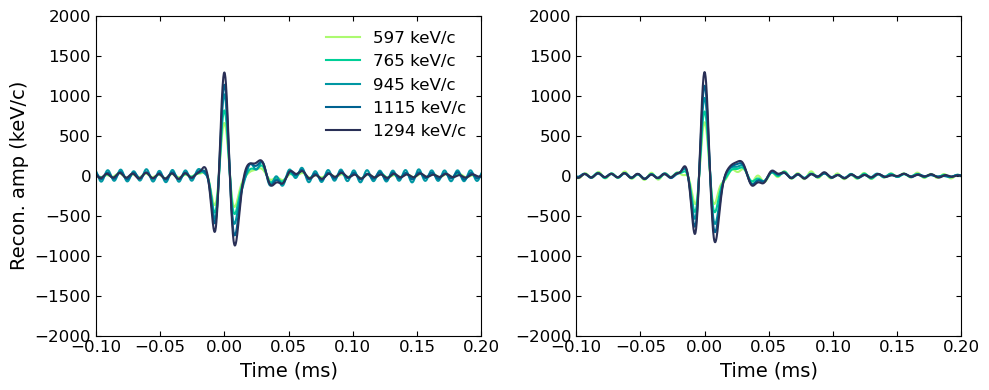

In [11]:
colors = ['#292f56', '#006290', '#0097a3', '#00cf97', '#acfa70']
pulse_amps = [597, 765, 945, 1115, 1294]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

dtt = 2e-7
for i, v in enumerate([10, 12.5, 15, 17.5, 20]):
    axes[0].plot(np.arange(-1500, 1500, 1)*dtt/1e-3, get_pulse_shape_template('sphere_20241202', v, 7187.368332843102), label=f'{pulse_amps[i]} keV/c', color=colors[4-i])
    axes[1].plot(np.arange(-1500, 1500, 1)*dtt/1e-3, get_pulse_shape_template('sphere_20250103', v, 7157.624533259538), label=f'{pulse_amps[i]} keV/c', color=colors[4-i])

for ax in axes:
    ax.set_xlim(-0.1, 0.2)
    ax.set_ylim(-2000, 2000)
    ax.set_xlabel('Time (ms)')

axes[0].set_ylabel('Recon. amp (keV/c)')
axes[0].legend(frameon=False)

fig.tight_layout()

#### Example calibration events

In [12]:
## Read charging data
dir_filament = r'/Volumes/LaCie/pulse_calibration/discharging/filament_discharging'
dir_uv = r'/Volumes/LaCie/pulse_calibration/discharging/uv_discharging'

dtt_charging = 0.0001
_ee_filament = []
for i in range(1, 4):
    file_name = f'filament_discharging_{i}.csv'
    data = np.genfromtxt(os.path.join(dir_filament, file_name), delimiter=',', skip_header=2).T
    
    _ee_filament.append(data[-1])

_ee_uv = []
for i in range(1, 17):
    if i < 10:
        file_name = f'uv_discharging_0{i}.csv'
    else:
        file_name = f'uv_discharging_{i}.csv'
    data = np.genfromtxt(os.path.join(dir_uv, file_name), delimiter=',', skip_header=2).T
    
    _ee_uv.append(data[-1])

ee_filament = np.concatenate(_ee_filament)
ee_uv = np.concatenate(_ee_uv)

In [13]:
data_file = r'/Volumes/LaCie/pulse_calibration/sphere_20250103/20250117_8e_alignment1_8e-9mbar_0/20250117_dg_8e_200ns_20v_0.hdf5'

dtt, nn = utils.load_timestreams(data_file, ['D', 'G'])

fs = int(np.ceil(1/dtt))
zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

drive_indices = utils.get_pulse_idx(dd, 0.5, True)


/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5593/643170691.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


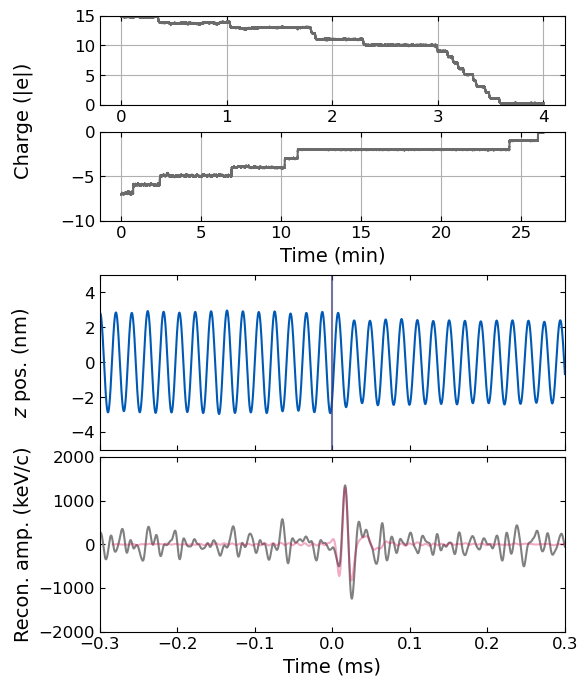

In [71]:
fig = plt.figure(figsize=(6, 8))

gs1 = GridSpec(4, 1, height_ratios=[1, 1, 2, 2])
gs1.update(hspace=0.2)

ax0, ax1 = plt.subplot(gs1[0]), plt.subplot(gs1[1])

gs2 = GridSpec(4, 1, height_ratios=[1.4, 1.4, 2, 2])
gs2.update(hspace=0.05)
ax2, ax3 = plt.subplot(gs2[2]), plt.subplot(gs2[3])

axes = [ax0, ax1, ax2, ax3]

## Plot charging data
axes[0].plot(np.arange(0, dtt_charging*ee_filament.size, dtt_charging)/60, ee_filament/0.103, color='#6B6B6B')
axes[1].plot(np.arange(0, dtt_charging*ee_uv.size, dtt_charging)/60, -1*ee_uv/0.376, color='#6B6B6B')

## Plot calibration waveform
pulse_shape_template = get_pulse_shape_template('sphere_20250103', 20, 7157.624533259538)

window, f, f_lp, amp = utils.recon_pulse(drive_indices[2], dtt, zz_bp, dd, 50000, 50000, 250, 20)
pulse_idx_in_win = np.argmin(np.abs(np.abs(f_lp/1e9) - amp))
tt_template = np.arange(pulse_idx_in_win-50000-1500, pulse_idx_in_win-50000+1500) * dtt

window_size = np.sum(window)
# Offset the applied pulse to center
axes[2].plot(np.arange(0, dtt*window_size, dtt)/1e-3 - 10, zz_bp[window] * c_mv / 1e-9, color='#005AB5')
axes[2].vlines(0, -5, 5, alpha=0.7)
axes[3].plot(np.arange(0, dtt*window_size, dtt)/1e-3 - 10, f_lp*amp2kev/1e9, color='grey')
axes[3].plot(tt_template/1e-3, pulse_shape_template, color='#D41159', alpha=0.35)

# window_1, f_1, f_lp_1, amp_1 = utils.recon_pulse(drive_indices[4], dtt, zz_bp, dd, 50000, 50000, 250, 20)
# pulse_idx_in_win_1 = np.argmin(np.abs(np.abs(f_lp_1/1e9) - amp_1))
# tt_template_1 = np.arange(pulse_idx_in_win_1-50000-1500, pulse_idx_in_win_1-50000+1500) * dtt

# window_size_1 = np.sum(window_1)
# axes[1, 1].plot(np.arange(0, dtt*window_size_1, dtt)/1e-3 - 10, zz_bp[window_1] * c_mv / 1e-9, color='#005AB5')
# axes[1, 1].vlines(0, -5, 5, alpha=0.7)
# axes[2, 1].plot(np.arange(0, dtt*window_size_1, dtt)/1e-3 - 10, f_lp_1*amp2kev/1e9, color='grey')
# axes[2, 1].plot(tt_template_1/1e-3, pulse_shape_template, color='#D41159', alpha=0.2)

axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_yticks([0, 5, 10, 15])
axes[1].set_yticks([0, -5, -10])

for i in [0, 1]:
    axes[i].grid()
axes[0].set_ylabel('Charge (|e|)', y=-0.175)
axes[1].set_xlabel('Time (min)')

axes[2].set_ylabel('$z$ pos. (nm)')
axes[3].set_ylabel('Recon. amp. (keV/c)')

axes[0].set_ylim(0, 15)
axes[1].set_ylim(-10, 0)

axes[2].set_xlim(-0.3, 0.3)
axes[3].set_xlim(-0.3, 0.3)

axes[2].set_ylim(-5, 5)
axes[3].set_ylim(-2000, 2000)

axes[2].set_xticklabels([])
axes[3].set_xlabel('Time (ms)')

fig.align_labels()
plt.tight_layout()

plt.savefig('/Users/yuhan/work/nanospheres/dm_nanospheres/paper_plots/charging_impulse_calibration_demo.pdf', dpi=600, bbox_inches='tight')


In [12]:
def get_normalized_template(sphere, voltage, bounds=(1000, 2000), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

    # Take the central values around the peak
    ret = normalized_template[bounds[0]:bounds[1]]

    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

In [13]:

def get_chisquares_calibration(sphere, voltage, normalized_template, sigma_amp, bounds=(1000, 2000), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']

    chisquares = np.empty(pulse_shapes.shape[0])
    chisquares_neg = np.empty(pulse_shapes.shape[0])
    for i, pulse in enumerate(pulse_shapes):
        pulse_test = pulse[bounds[0]:bounds[1]]
        if downsampled:
            pulse_test = decimate(pulse_test, 10)

        pulse_test_neg = -1 * pulse_test

        # The store pulse shapes are already positive going
        amp = np.max(pulse_test)
        template_scaled = normalized_template * amp

        chisquares[i] = np.sum( ((pulse_test - template_scaled)/sigma_amp)**2 )
        chisquares_neg[i] = np.sum( ((pulse_test_neg - template_scaled)/sigma_amp)**2 )

    return chisquares, chisquares_neg

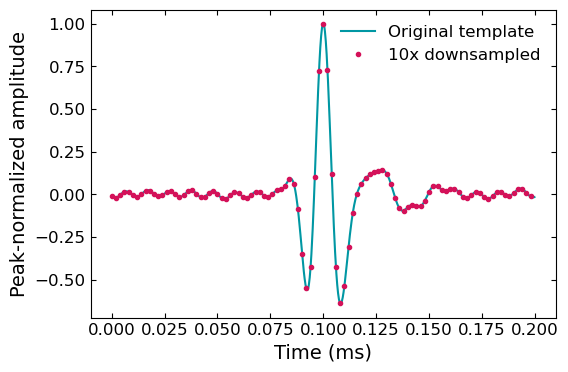

In [14]:
colors = ['#292f56', '#006290', '#0097a3', '#00cf97', '#acfa70']

normalized_template = get_normalized_template('sphere_20250103', 20, (1000, 2000), False)
normalized_template_downsampled = get_normalized_template('sphere_20250103', 20, (1000, 2000), True)

dtt = 2e-7 # 200 ns sampling interval for the calibration data
tt = np.arange(0, 1000, 1)*dtt/1e-3
tt1 = np.arange(0, normalized_template_downsampled.size, 1)*dtt*10/1e-3

plt.figure(figsize=(6, 4))
plt.plot(tt, normalized_template, label='Original template', color=colors[2])
plt.plot(tt1, normalized_template_downsampled, '.', label='10x downsampled', color='#D41159')
plt.xlabel('Time (ms)')
plt.ylabel('Peak-normalized amplitude')
plt.legend(frameon=False)

## Calculate the $\chi^2$'s of the calibration pulses
The templates and all pulses are downsampled by 10x to match the sampling rate of the actual DM data

In [15]:
normalized_template_downsampled_long = get_normalized_template('sphere_20250103', voltage=20, bounds=(1000, 2000), downsampled=True)
normalized_template_downsampled_short = get_normalized_template('sphere_20250103', voltage=20, bounds=(1250, 1750), downsampled=True)

In [16]:
sphere = 'sphere_20250103'
voltages = [10, 12.5, 15, 17.5, 20]

chisquares_cal_long,chisquares_cal_neg_long  = [], []
chisquares_cal_short,chisquares_cal_neg_short  = [], []
for i, v in enumerate(voltages):
    cc_long = get_chisquares_calibration(sphere, v, normalized_template_downsampled_long, sigma_p/amp2kev, bounds=(1000, 2000), downsampled=True)
    cc_short = get_chisquares_calibration(sphere, v, normalized_template_downsampled_short, sigma_p/amp2kev, bounds=(1250, 1750), downsampled=True)

    chisquares_cal_long.append(cc_long[0])
    chisquares_cal_neg_long.append(cc_long[1])

    chisquares_cal_short.append(cc_short[0])
    chisquares_cal_neg_short.append(cc_short[1])


In [17]:
# Calculate chi square for noise
sigma = sigma_p / amp2kev

chisquares_noise_long, chisquares_noise_short = np.empty(1600), np.empty(1600)
for i in range(1600):
    noise_long = np.random.normal(scale=sigma_p/amp2kev, size=100)
    noise_short = np.random.normal(scale=sigma_p/amp2kev, size=50)

    amp = noise_long[50]
    template_scaled_long = normalized_template_downsampled_long * amp
    chisquares_noise_long[i] = np.sum( ((noise_long - template_scaled_long)/sigma)**2 )

    amp = noise_short[25]
    template_scaled_short = normalized_template_downsampled_short * amp
    chisquares_noise_short[i] = np.sum( ((noise_short - template_scaled_short)/sigma)**2 )

Threshold = 200 (0.2 ms window), 150 (0.1 ms window)
Fraction rejected (597 keV/c): 0.059, 0.024
Fraction rejected (765 keV/c): 0.033, 0.011
Fraction rejected (945 keV/c): 0.039, 0.015
Fraction rejected (1115 keV/c): 0.045, 0.024
Fraction rejected (1294 keV/c): 0.066, 0.038
Fraction rejected (averaged): 0.056 $\pm$ 0.011, 0.031 $\pm$ 0.007
Fraction rejected (noise): 0.0, 0.0


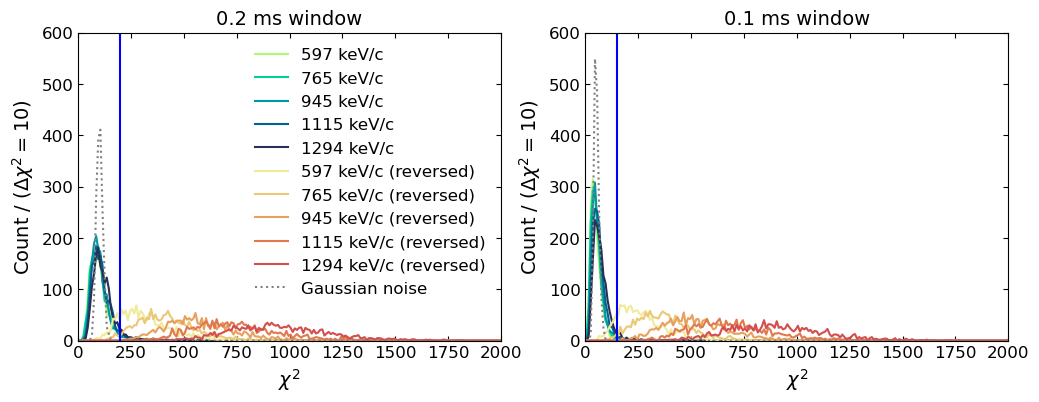

In [ ]:
colors_warm = ['#d44e4e', '#e07950', '#e8a15c', '#ecc775', '#f0eb99']
pulse_amps = [597, 765, 945, 1115, 1294]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
bins = np.arange(0, 2500, 10)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, chisquares in enumerate(chisquares_cal_long):
    hh, be = np.histogram(chisquares, bins=bins)
    ax.plot(bc, hh, label=fr'{pulse_amps[i]} keV/c', color=colors[4-i])

for i, chisquares in enumerate(chisquares_cal_neg_long):
    hh_n, be_n = np.histogram(chisquares_cal_neg_long[i], bins=bins)
    ax.plot(bc, hh_n, '-', label=fr'{pulse_amps[i]} keV/c (reversed)', color=colors_warm[4-i])

    if i == 4:
        hh_noise, be_noise = np.histogram(chisquares_noise_long, bins=bins)
        bc_noise = 0.5 * (be_noise[:-1] + be_noise[1:])
        ax.plot(bc_noise, hh_noise, ':',label=f'Gaussian noise', color='grey')

ax.set_title('0.2 ms window')
ax.legend(frameon=False)

## Second plot for short template
ax = axes[1]
bins = np.arange(0, 2500, 10)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, chisquares in enumerate(chisquares_cal_short):
    hh, be = np.histogram(chisquares, bins=bins)
    ax.plot(bc, hh, label=fr'{pulse_amps[i]} keV/c', color=colors[4-i])

for i, chisquares in enumerate(chisquares_cal_neg_short):
    hh_n, be_n = np.histogram(chisquares, bins=bins)
    ax.plot(bc, hh_n, '-', label=fr'{pulse_amps[i]} keV/c (reversed)', color=colors_warm[4-i])

    if i == 4:
        hh_noise, be_noise = np.histogram(chisquares_noise_short, bins=bins)
        bc_noise = 0.5 * (be_noise[:-1] + be_noise[1:])
        ax.plot(bc_noise, hh_noise, ':',label=f'Gaussian noise', color='grey')
ax.set_title('0.1 ms window')

for ax in axes:
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 600)

    ax.set_ylabel(r'Count / ($\Delta \chi^2=10$)')
    ax.set_xlabel(r'$\chi^2$')

thr_long  = 200
thr_short = 150
axes[0].vlines(thr_long, 0, 600, color='b')
axes[1].vlines(thr_short, 0, 600, color='b')

print(f'Threshold = {thr_long} (0.2 ms window), {thr_short} (0.1 ms window)')

fractions_long, fractions_short = np.empty(5), np.empty(5)
for i, chisquares in enumerate(chisquares_cal_long):
    fractions_long[i] = (np.sum(chisquares > thr_long) / chisquares.size)
    fractions_short[i] = (np.sum(chisquares_cal_short[i] > thr_short) / chisquares_cal_short[i].size)

    print(f'Fraction rejected ({pulse_amps[i]} keV/c): {fractions_long[i]:.3f}, {fractions_short[i]:.3f}')

print(fr'Fraction rejected (averaged): {np.mean(fractions_long[-2:]):.3f} $\pm$ {np.std(fractions_long[-2:]):.3f}, {np.mean(fractions_short[-2:]):.3f} $\pm$ {np.std(fractions_short[-2:]):.3f}')
print(f'Fraction rejected (noise): {np.sum(chisquares_noise_long > thr_long) / chisquares_noise_long.size}, {np.sum(chisquares_noise_short > thr_short) / chisquares_noise_short.size}')